# Solution

## Clustering

In [17]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from tqdm import tqdm_notebook
%matplotlib inline
#make wider graphs


from functions.others import *
from functions.cluster import *
from functions.ml_model import *
from functions.expand import *

%load_ext autoreload
%autoreload 2


from TrackML.dataset import load_event



event_num=0
event_prefix = 'event00000100{}'.format(event_num)
hits, cells, particles, truth = load_event(os.path.join('data/train_100_events', event_prefix))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
history=[]
weights={'pi':1,'theta':0.15}
stds={'z0':7.5, 'kt':7.5e-4}
d =    {'sint':[225,110,110,110,110,110],
        'cost':[225,110,110,110,110,110],
          'phi':[550,260,260,260,260,260],
        'min_group':[11,11,10,9,8,7],
        'npoints':[500,2000,1000,1000,500,500]}
filters=pd.DataFrame(d)
nu=500

resa1=clustering(hits,stds,filters,phik=3.3)
resa1["event_id"]=event_num
score = score_event_fast(truth, resa1.rename(index=str, columns={"label": "track_id"}))
print("Your score: ", score)

resa2=clustering(hits,stds,filters,phik=3.3)
resa2["event_id"]=event_num
score = score_event_fast(truth, resa2.rename(index=str, columns={"label": "track_id"}))
print("Your score: ", score)

100%|██████████| 5500/5500 [04:04<00:00, 22.46it/s]


Your score:  0.6296952


100%|██████████| 5500/5500 [04:04<00:00, 22.51it/s]


Your score:  0.64070755


## ML

In [3]:
df_train = load_obj('training/pro_train.pkl')
df_test = load_obj('training/pro_test.pkl')
df_train.head()

,svolume,nhits,nclusters,nhitspercluster,xmax,ymax,zmax,xmin,ymin,zmin,zmean,xvar,yvar,zvar,target,event_id
62155,8,5,4,1.250000,867.354004,62.742001,-94.909302,32.031799,3.643290,-2952.500000,-1784.316040,174471.281250,825.944946,2.032157e+06,0,11
62156,9,12,7,1.714286,102.637001,-6.704750,1502.000000,42.175800,-26.253099,597.500000,963.500000,468.160522,49.322369,1.049627e+05,0,11
62157,8,13,10,1.300000,38.930599,-27.530500,6.669020,-130.085007,-1020.609985,-119.199997,-37.094341,2592.830566,92939.093750,1.422339e+03,1,11
62158,9,8,7,1.142857,-135.658997,-9.099930,2548.500000,-544.049011,-161.845001,602.000000,1402.187500,23747.388672,3128.332275,5.299227e+05,0,11
62159,9,12,6,2.000000,62.528301,-16.695400,1502.500000,29.593700,-37.467098,697.500000,956.833313,109.255455,43.020386,6.491688e+04,0,11


In [4]:
import lightgbm
import time

s = time.time()

columns=['svolume','nclusters', 'nhitspercluster', 'xmax','ymax','zmax', 'xmin','ymin','zmin', 'zmean',
         'xvar','yvar','zvar']
rounds = 1000
rounds_early_stop = 100 
parameters = {'subsample_for_bin': 800, 'max_bin': 512, 'num_threads':4,
              'application': 'binary', 'objective': 'binary', 'metric': 'auc',
              'boosting': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.7,
              'learning_rate': 0.05, 'verbose':0}

train_data = lightgbm.Dataset(df_train[columns].values, label=df_train.target.values)
test_data = lightgbm.Dataset(df_test[columns].values, label=df_test.target.values)

model = lightgbm.train(parameters, train_data, valid_sets=test_data, num_boost_round=rounds, 
                       early_stopping_rounds=rounds_early_stop, verbose_eval=100)

print('took',time.time()-s,'seconds')

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.968203
[200]	valid_0's auc: 0.973896
[300]	valid_0's auc: 0.975539
[400]	valid_0's auc: 0.976111
[500]	valid_0's auc: 0.976459
[600]	valid_0's auc: 0.976706
[700]	valid_0's auc: 0.976935
[800]	valid_0's auc: 0.977078
[900]	valid_0's auc: 0.977179
[1000]	valid_0's auc: 0.977232
Did not meet 

In [5]:
preds1 = get_predictions(resa1, hits, model)
preds2 = get_predictions(resa2, hits, model)

In [6]:
preds1.head()

,track_id,quality
0,1002963,0.866719
1,1070281,0.629514
2,1079687,0.876269
3,1082066,0.738505
4,1086487,0.905611


In [7]:
th = np.arange(0.1, 1, 0.1)
scores = []
for t in th:
    sub01=merge_with_probas(resa1,resa2,preds1,preds2, len_factor=t)
    score = score_event_fast(truth, sub01)
    scores.append(score)

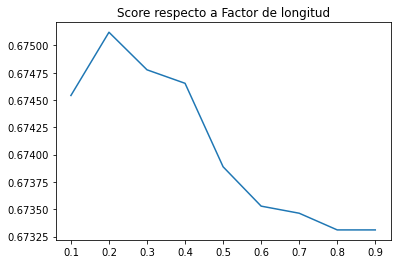

In [8]:
plt.plot(th, scores)
plt.title('Score respecto a Factor de longitud')
plt.show()

In [11]:
sub01=merge_with_probas(resa1,resa2,preds1,preds2, len_factor=0.2)
score = score_event_fast(truth, sub01)
print('Score: ', score)

Score:  0.6751213


In [55]:
mstd_vol={7:0,8:0,9:0,12:2,13:1,14:2,16:3,17:2,18:3}
mstd_size=[4,4,4,4,3,3,3,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
weights={'theta':0.1, 'phi':1}
nresa=expand_tracks(sub01,hits,5,16,5,7,mstd=8,dstd=0.00085,max_dtheta=0.9*np.pi/2,mstd_vol=mstd_vol,mstd_size=mstd_size,weights=weights,nhipo=100)
nresa['event_id']=0
score = score_event_fast(truth, nresa)
print("Your score: ", score)

100%|██████████| 7293/7293 [04:36<00:00, 26.40it/s]


Your score:  0.7198924


max_theta

+ \> : 0.7198225
+ \< : 0.7197966


dtheta
+ \> : 0.72008586
+ \< : 0.7200979

Falso
+ F : 0.7202403

In [ ]:
nresa.head()

,hit_id,track_id,event_id,kt,z0,track_len,max_track_len,x,y,z,...,phi,sint,cost,fault,phi2,theta2,sint2,cost2,dist,dist2
0,95656,9525,0,-0.000506,10.431745,1,6,38.913898,660.633972,379.000000,...,0.113217,0.982956,0.183841,0,0.982117,4.779610,-0.997742,0.067170,0.625155,0.764059
1,84353,14564,0,0.001202,4.749806,1,6,358.092010,21.757099,768.599976,...,0.377363,-0.007524,0.999972,0,0.991281,3.270484,-0.128535,-0.991705,0.590370,0.762012
2,91233,10752,0,0.000781,-1.927114,1,6,-470.885010,155.901001,908.400024,...,0.331644,0.402362,-0.915481,0,0.992556,6.057837,-0.223446,0.974716,0.373713,0.914288
3,23309,29174,0,0.001002,12.167179,1,6,-29.165501,11.898600,53.554199,...,0.333668,0.383276,-0.923634,0,0.887806,5.901813,-0.372195,0.928155,0.368844,0.815683
4,65433,8602,0,0.002264,-0.201315,1,6,-240.306000,357.964996,-2551.500000,...,-0.692238,0.873129,-0.487489,0,-0.997341,5.385600,-0.781824,0.623500,1.081269,1.323530


In [ ]:
score = score_event_fast(truth, nresa)
print("Your score: ", score)

In [54]:
def binary_cluster_merge(stage):
    if stage==0:
        weights={'pi':1,'theta':0.15}
        stds={'z0':7.5, 'kt':7.5e-4}
        d =    {'sint':[225,110,110],
                'cost':[225,110,110],
                  'phi':[550,260,260],
                'min_group':[11,11,10],
                'npoints':[250,1250,750]}
        filters=pd.DataFrame(d)
        nu=250
        res=clustering(hits,stds,filters,phik=3.3)
        res["event_id"]=event_num
        score = score_event_fast(truth, res.rename(index=str, columns={"label": "track_id"}))
        print("Your score: ", score)
    else:
        res1=binary_cluster_merge(stage-1)
        res2=binary_cluster_merge(stage-1)
        preds1=get_predictions(res1,hits,model)
        preds2=get_predictions(res2,hits,model)
        print('Merge submission stage:',stage)
        res=merge_with_probas(res1,res2,preds1,preds2,len_factor=0.3)
        score = score_event_fast(truth, res)
        print('Score:',score)
    return(res)

res = binary_cluster_merge(2)
mstd_vol={7:0,8:0,9:0,12:2,13:1,14:2,16:3,17:2,18:3}
mstd_size=[4,4,4,4,3,3,3,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
weights={'theta':0.1, 'phi':1}
res=expand_tracks(res,hits,5,16,5,7,mstd=8,dstd=0.00085,max_dtheta=0.9*np.pi/2,mstd_vol=mstd_vol,mstd_size=mstd_size,weights=weights,nhipo=100)
res['event_id']=0
score = score_event_fast(truth, res)
print("Your score: ", score)

100%|██████████| 2250/2250 [01:49<00:00, 20.46it/s]


Your score:  0.5778391


100%|██████████| 2250/2250 [01:53<00:00, 19.85it/s]


Your score:  0.5783031
Merge submission stage: 1
Score: 0.6317919


100%|██████████| 2250/2250 [01:51<00:00, 20.13it/s]


Your score:  0.572158


100%|██████████| 2250/2250 [01:51<00:00, 20.20it/s]


Your score:  0.570621
Merge submission stage: 1
Score: 0.62785524
Merge submission stage: 2
Score: 0.6754864


100%|██████████| 7165/7165 [04:20<00:00, 27.53it/s]


Your score:  0.71954924


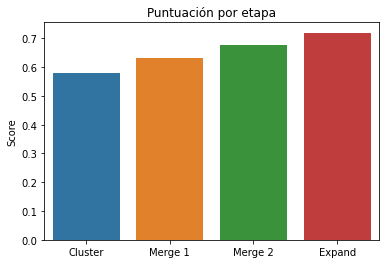

In [57]:
stages = ['Cluster', 'Merge 1', 'Merge 2', 'Expand']
scores = [0.5783031, 0.6317919, 0.6754864, 0.71954924]
sns.barplot(stages, scores)
plt.title('Puntuación por etapa')
plt.ylabel('Score')
plt.show()

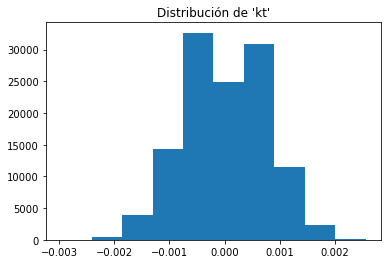

In [60]:
plt.hist(res.kt)
plt.title('Distribución de \'kt\'')
plt.show()

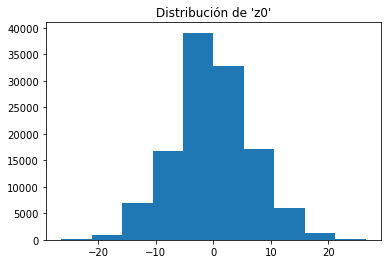

In [61]:
plt.hist(res.z0)
plt.title('Distribución de \'z0\'')
plt.show()

In [66]:
res_track = res.merge(hits, on='hit_id', how='left')
res_track.head()

,hit_id,track_id,kt,z0,event_id,x,y,z,volume_id,layer_id,module_id
0,59765,8255,-0.000157,-0.632041,0,-43.730499,-0.144389,1097.500000,9,10,106
1,41468,8795,-0.000169,-10.470403,0,-21.191799,-172.128006,-191.123993,8,8,331
2,94160,29709,-0.000670,-9.423549,0,-637.159973,-173.895996,9.000000,13,8,1025
3,41466,22992,0.000666,6.203313,0,-21.008200,-170.158997,-189.050995,8,8,330
4,20393,875,0.000208,1.957359,0,30.713400,8.914210,-11.450900,8,2,105


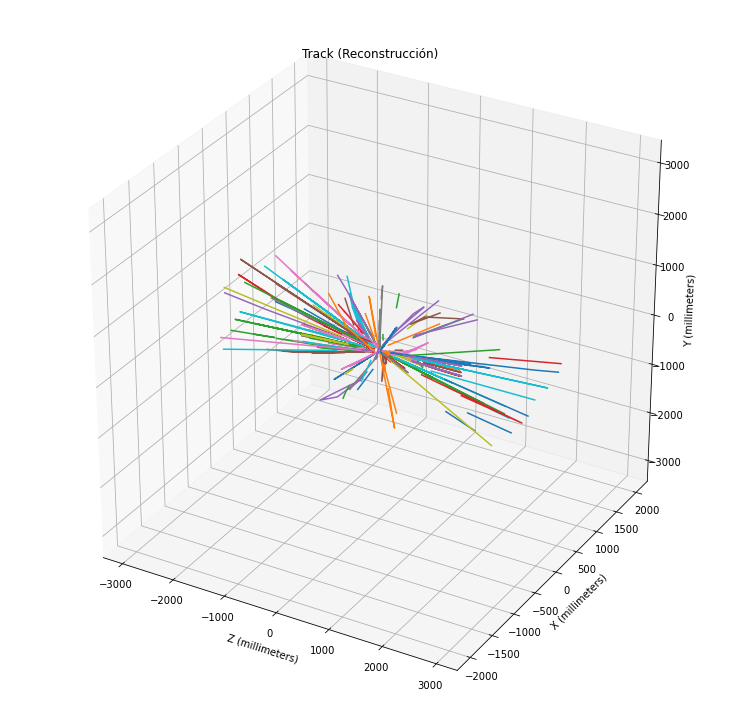

In [73]:
tracks = res_track.track_id.unique()[1::200]

plt.figure(figsize=(13,13))
ax = plt.axes(projection='3d')

for track in tracks:
    t = res_track[res_track.track_id == track]
    ax.plot3D(t.z, t.x, t.y)
ax.set_title('Track (Reconstrucción)')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.scatter(2000,2000,3000, s=0)
ax.scatter(-2000,-2000,-3000, s=0)
plt.show()    

In [77]:
track_com = res_track.merge(truth, on='hit_id', how='left')
track_com.head(10)

,hit_id,track_id,kt,z0,event_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,59765,8255,-0.000157,-0.632041,0,-43.730499,-0.144389,1097.500000,9,10,106,445868251579154432,-43.726799,-0.144340,1097.500000,-1.386000,-0.019751,34.990299,0.000010
1,41468,8795,-0.000169,-10.470403,0,-21.191799,-172.128006,-191.123993,8,8,331,301742686862311424,-21.193300,-172.128006,-191.119995,-0.168350,-1.799700,-1.891800,0.000018
2,94160,29709,-0.000670,-9.423549,0,-637.159973,-173.895996,9.000000,13,8,1025,364803458286485504,-637.158020,-173.908997,8.487160,-0.338352,-0.298054,0.010237,0.000005
3,41466,22992,0.000666,6.203313,0,-21.008200,-170.158997,-189.050995,8,8,330,301742686862311424,-21.008801,-170.158997,-189.050995,-0.169331,-1.799670,-1.891780,0.000024
4,20393,875,0.000208,1.957359,0,30.713400,8.914210,-11.450900,8,2,105,153126579218677760,30.713100,8.914920,-11.447600,1.416120,0.400333,-0.607645,0.000032
5,43205,7320,-0.000240,-1.096009,0,61.744900,-159.246002,69.612198,8,8,570,675540906178248704,61.744099,-159.246002,69.616203,0.527797,-1.215300,0.550782,0.000013
6,4767,22971,0.000683,-1.781375,0,0.401166,50.025200,-1098.000000,7,6,79,873710765935165440,0.382051,50.034901,-1098.000000,-0.012108,0.476796,-10.484700,0.000010
7,23123,9626,0.000427,4.913549,0,-13.220100,28.683399,0.603127,8,2,125,639531144454340608,-13.206200,28.688299,0.604163,-0.287413,0.649487,-0.093260,0.000014
8,115949,16246,0.000161,8.466544,0,954.791016,-372.592987,222.199997,17,4,1891,337773545465577472,954.807983,-372.565002,220.699997,1.638790,-0.973454,0.392929,0.000024
9,97528,14784,0.000267,11.437306,0,42.559101,-616.416992,1215.500000,14,2,45,180146184118075392,42.580502,-616.851990,1215.500000,-0.096714,-1.139990,2.229820,0.000010


In [83]:
df = track_com.groupby('track_id')['hit_id'].count().reset_index().sort_values('hit_id', ascending=False)
df[df.hit_id < 15].head()

,track_id,hit_id
1289,1316,14
27595,29447,14
1285,1312,14
737,757,14
703,721,14


In [120]:
df[df.hit_id < 9].head()

,track_id,hit_id
30002,32041,8
22519,24019,8
4293,4508,8
15112,16022,8
18730,19898,8


In [121]:
tracks = [7162, 14956, 30332, 18576, 2450, 20598, 15894, 19898, 4508]
particles = []
for t in tracks:
    particles.append(track_com[track_com.track_id == t].particle_id.unique()[0])
particles

[364812666696368128,
 828664667898380288,
 558463464943648768,
 571958527065587712,
 292750674611929088,
 180146665154412544,
 103592961912078336,
 189151253069037568,
 445858149816074240]

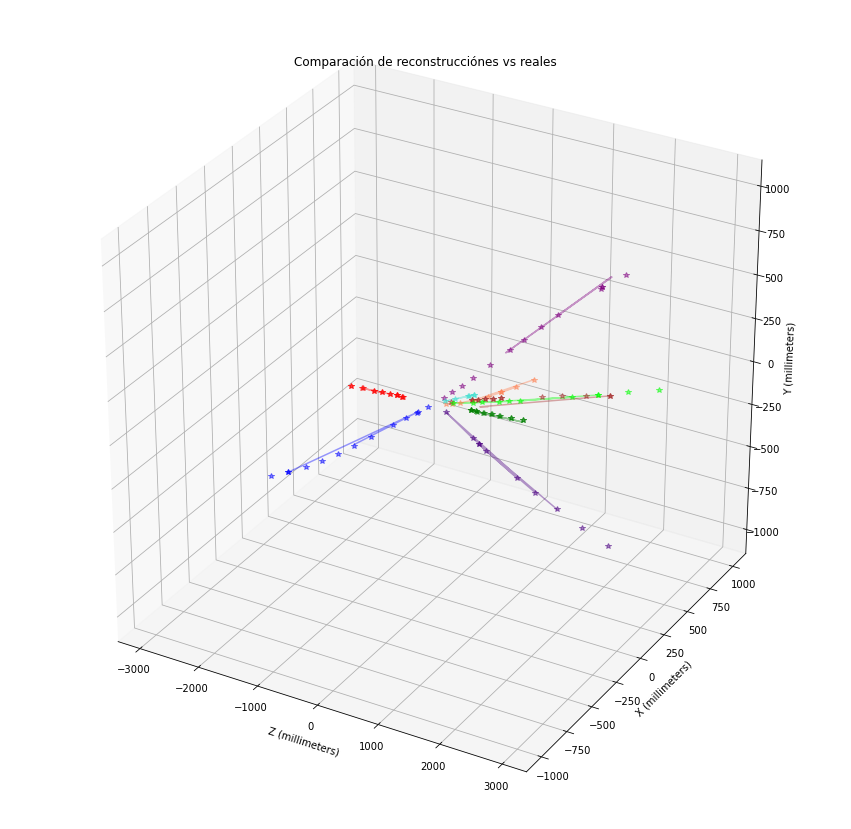

In [122]:


plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
colors = ['red', 'blue', 'green', 'purple', 'coral', 'turquoise', 'brown', 'indigo', 'lime']

for track, col in zip(tracks, colors):
    t = track_com[track_com.track_id == track]
    ax.plot3D(t.z, t.x, t.y, color=col, alpha=0.4)
for part, col in zip(particles, colors):
    t = track_com[track_com.particle_id == part]
    ax.plot3D(t.z, t.x, t.y, '*', color=col, alpha=0.5)
ax.set_title('Comparación de reconstrucciónes vs reales')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.scatter(1000,1000,1000, s=0)
ax.scatter(-1000,-1000,-1000, s=0)
plt.show() 